In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

In [ ]:
# prompt: pip install bertopic

!pip install bertopic


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

In [ ]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load stopwords from the provided stopwords file
with open('/content/stopwords-mr.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())


In [ ]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords and word.isalnum()]
    return ' '.join(tokens)


In [ ]:
df = pd.read_csv("/content/marathi_ag.csv")


In [ ]:
# Regular expression pattern to match Twitter hashtag
pattern = r'"#\w+", "",'

# Function to remove Twitter hashtags from text
def remove_twitter_hashtags(tweet):
    return re.sub(pattern, '', tweet)

# Apply the function to each element in the 'text' column
df['tweet'] = df['tweet'].apply(remove_twitter_hashtags)


In [ ]:
# Define the pattern correctly
pattern = r"http[s]?://\S+"

def remove_twitter_hyperlinks(tweet):
    return re.sub(pattern, '', tweet)

# Apply the function to the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(remove_twitter_hyperlinks)

In [ ]:
# Function to remove URLs and unwanted characters
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(pattern, '', tweet)
    # Remove unwanted characters
    tweet = re.sub(r"[^\u0900-\u097Fa-zA-Z0-9\s]", "", tweet)
    return tweet

# Apply the function to the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(clean_tweet)

In [ ]:
# Define the pattern for emojis
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE
)

def remove_emojis(tweet):
    return emoji_pattern.sub(r'', tweet)

# Apply the function to the 'tweet' column of the DataFrame
df['tweet'] = df['tweet'].apply(remove_emojis)

In [ ]:
# prompt: pip install emoji

!pip install emoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
import emoji
def remove_emojis(text):
  return emoji.demojize(text, delimiters=(" ", " "))

df['tweet'] = df['tweet'].apply(remove_emojis)



In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', ' ', x))



In [ ]:
documents = df['tweet'].dropna().tolist()[:16000]  # Drop NaNs and limit to 16000 rows
processed_docs = [preprocess(doc) for doc in documents]


In [ ]:
df.head()

,tid,tweet
0,1,गंमत बघा खालची उत्तरं वाचा प्रश्न साधा पण तुमच...
1,2,VikasDe90360343 म्हणजे मुस्लिम बौद्ध आणि ख्रिश...
2,3,माझ्यावर होणाऱ्या टीकेला शांतपणे घेतोय तुम्ही ...
3,4,भारत ही विचारांची जागतिक राजधानी \nयुवा पिढील...
4,5,संजय राऊत यांनी रचले नवाब मलिक यांच्या विरुद्ध...


In [ ]:
# Train BERTopic model
vectorizer_model = CountVectorizer()
topic_model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(processed_docs)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Display topics
topics_info = topic_model.get_topic_info()
print(topics_info.head(10))


   Topic  Count                                               Name  \
0     -1   2854                 -1_dwalsepatil_sc_ajil_mnsadhikrut   
1      0   2581                             0_uppl_sh_pshah_others   
2      1    346     1_meneeleshnrane_bmc_sandipbel23_nikhilpatil60   
3      2    281                         2_beinglove_blessed_xx_rip   
4      3    164  3_bjp4mumbai_bjp4maharashtra_prasadladind_bjp4...   
5      4    126  4_uddhavthackeray_mahavikasaghadi_punjab_shara...   
6      5    121     5_lovejihaad_realsubodh_nileshdhotre18_mahakal   
7      6    100  6_tv9marathi_ncpspeaks_bjp4maharashtra_dwalsep...   
8      7     97                        7_numbari_broken_satejp_dus   
9      8     96                          8_11pmwords_700_5050_5000   

                                      Representation  \
0  [dwalsepatil, sc, ajil, mnsadhikrut, rajthacke...   
1  [uppl, sh, pshah, others, nice, da, efforts, h...   
2  [meneeleshnrane, bmc, sandipbel23, nikhilpatil...   
3  [b

In [ ]:
# prompt: download Representative_Docs  as csv

import pandas as pd
representative_docs = topic_model.get_representative_docs() # Use get_representative_docs() method
df_representative_docs = pd.DataFrame(representative_docs, columns=['Topic', 'Document'])
df_representative_docs.to_csv('Representative_Docs.csv', index=False)

In [ ]:
import pandas as pd
from bertopic import BERTopic

# Assuming you have a BERTopic model named topic_model
# and it has already been trained with your data

# Retrieve the representative documents for each topic
representative_docs = topic_model.get_representative_docs()

# Convert the representative documents into a DataFrame
df_representative_docs = pd.DataFrame([(topic, doc) for topic, docs in representative_docs.items() for doc in docs],
                                      columns=['Topic', 'Document'])

# Save the DataFrame as a CSV file
df_representative_docs.to_csv('Representative_Docs.csv', index=False)


In [ ]:
# Extract and display representative sentences for each topic
def display_representative_sentences(df, topics, num_topics=10, num_sentences=5):
    for topic_id in range(num_topics):
        print(f"\nTopic {topic_id}:")
        topic_docs_indices = [i for i, topic in enumerate(topics) if topic == topic_id]
        representative_sentences = [df['tweet'].iloc[i] for i in topic_docs_indices[:num_sentences]]
        for idx, sentence in enumerate(representative_sentences, 1):
            print(f"{idx}. {sentence}")

display_representative_sentences(df, topics)



Topic 0:
1. संजय राऊत यांनी रचले नवाब मलिक यांच्या विरुद्ध षडयंत्र
एक दिवस अगोदर यांना कसं माहित होत कारवाई होणार आहे ते पण युती धर्म पाळून त्यांना मालिकांना सांगितलं नाही

हे चुकीचे आहे की नाही सांगा तुम्हीच 
2. 34 महिने शेळीच्या लहान पिल्लावर प्रेम करून एक दिवस कापून खाणाऱ्या गाचपान ढवळयाना

काल माशांची काळजी वाटत होतीBSDK
 
3. लगेच दुसर्याच दिवशी पहाटे का हल्ला चढवला आजाद मैदानावर  कमी पडलेल्या कर्मचार्यांना ऊचलण्यासाठीच 
4. 2
अती लोभ आणी जना नित्य लाज
अती त्याग तो रोकडा मृत्य आज ।
सदा तृप्त नेमस्त सर्वां दिसावे
प्रमाणामधे सर्व काही असावे ।।
5. भाजपच्या प्रदेश उपाध्यक्ष सौ चित्रा वाघ यांच्या मुक्त सैनिक वसाहत येथील सभेवेळी झालेली दगडफेक ही पूर्वनियोजित आणि भाजप चे षडयंत्र आहे हे घडविण्या मागे भाजपचे समीर शेठ आहेत असा आम्हाला संशय आहेया कथित दगडफेक  घटनेबद्दल सखोल चौकशी करून खऱ्या आरोपींवर का

Topic 1:
1. meNeeleshNRane अजित पवार एक नंबर धोकेबाज आणि खोटं बोलणारे माणूस
2. meNeeleshNRane असा निष्क्रिय आणि बेजबाबदार मुख्यमंत्री कोणत्या राज्याला नको लाभू दे

याला सर्व जबाबदार पवार साहेब

In [ ]:
# Plot word clouds for top 10 topics
def plot_wordcloud(topic_model, topic_id):
    words = dict(topic_model.get_topic(topic_id))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_id}")
    plt.show()


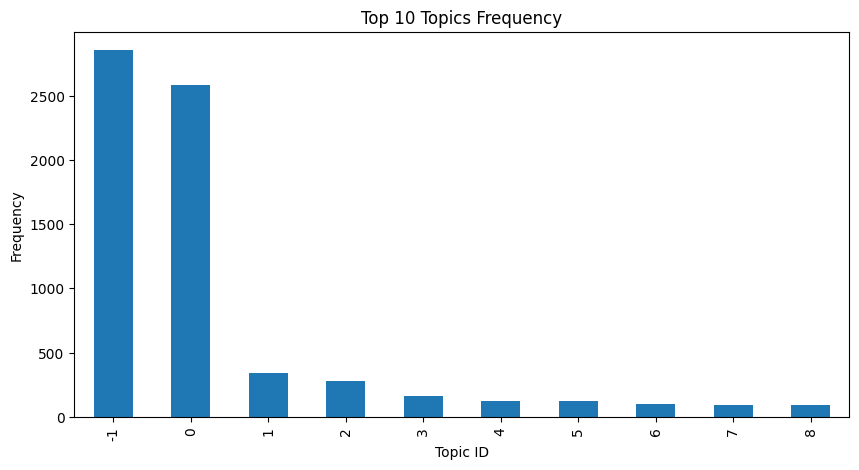

In [ ]:
# Plot the top 10 topics frequency and list the topic labels
topic_counts = topics_info.set_index('Topic').loc[topics_info['Topic'][:10], 'Count']
topic_labels = [topic_model.get_topic(topic_id) for topic_id in topics_info['Topic'][:10]]

plt.figure(figsize=(10, 5))
topic_counts.plot(kind='bar')
plt.xlabel('Topic ID')
plt.ylabel('Frequency')
plt.title('Top 10 Topics Frequency')
plt.show()



In [ ]:
# Print the topic labels
for i, (topic_id, topic_label) in enumerate(zip(topics_info['Topic'][:10], topic_labels), 1):
    words = ', '.join([word for word, _ in topic_label])
    print(f"Topic {topic_id}: {words}")

Topic -1: dwalsepatil, sc, ajil, mnsadhikrut, rajthackeray, ncpspeaks, eknathshinde, kishoripednekar, bodkheshilpa, mieknathshinde
Topic 0: uppl, sh, pshah, others, nice, da, efforts, hi, evening, try
Topic 1: meneeleshnrane, bmc, sandipbel23, nikhilpatil60, kimjongun2, st, tv, jcb, jshingate, up
Topic 2: beinglove, blessed, xx, rip, pacific, forward, crz, thank, morning, wa
Topic 3: bjp4mumbai, bjp4maharashtra, prasadladind, bjp4india, smungantiwar, shelarashish, chdadapatil, chitrakwagh, shreebharatiya, mipravindarekar
Topic 4: uddhavthackeray, mahavikasaghadi, punjab, sharadpawar, lokmat, chandrakantpatil, bjp, devendrafadnavis, kirit, somaiya
Topic 5: lovejihaad, realsubodh, nileshdhotre18, mahakal, dratulwadkar, kuchikr, deeeear, dasiirama, drsanjayrakibe, mahavitranwithfarmers
Topic 6: tv9marathi, ncpspeaks, bjp4maharashtra, dwalsepatil, officeofut, compare, waqfboard, praveen2482, ajitpawarspeaks, dired
Topic 7: numbari, broken, satejp, dus, checked, amoghsdhamale, chandukadamin

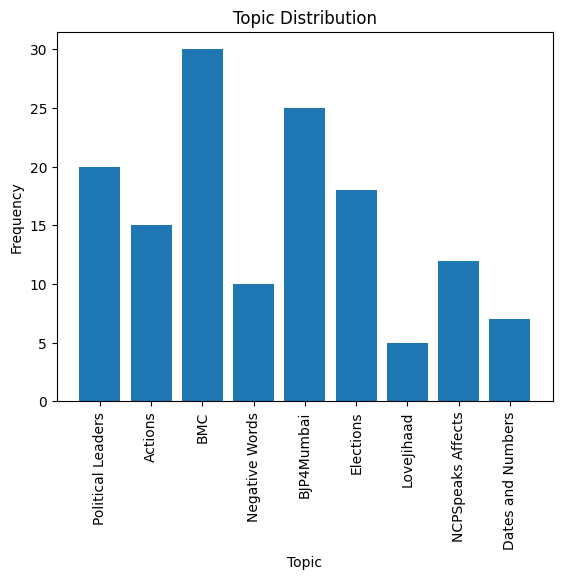

In [ ]:

import matplotlib.pyplot as plt

# Define the data
x = range(-1, 8)
y = [20, 15, 30, 10, 25, 18, 5, 12, 7]
labels = ["Political Leaders", "Actions", "BMC", "Negative Words", "BJP4Mumbai", "Elections", "LoveJihaad", "NCPSpeaks Affects", "Dates and Numbers"]

# Create the bar chart
plt.bar(x, y)
plt.xticks(x, labels, rotation=90)

# Set the title and axis labels
plt.title("Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")

# Show the chart
plt.show()
